## Deconvolution with Unrolled ADMM

This notebook is a tutorial on deconvolving galaxy images using our pretrained Unrolled ADMM model.

In [1]:
import sys
sys.path.append('../')
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from models.Unrolled_ADMM import Unrolled_ADMM
from models.Richard_Lucy import Richard_Lucy
from models.Tikhonet import Tikhonov, Tikhonet
from models.Wiener import Wiener
from utils.utils_test import PSNR, estimate_shear

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load data

In [2]:
psf = torch.load("psf.pth")
obs = torch.load("obs.pth")
gt = torch.load("gt.pth")
# psf = torch.load("../simulated_datasets/LSST_23.5_deconv/psf/psf_20.pth")
# obs = torch.load("../simulated_datasets/LSST_23.5_deconv/obs/obs_20.pth")
# gt = torch.load("../simulated_datasets/LSST_23.5_deconv/gt/gt_20.pth")

/tmp/ipykernel_879736/1594919022.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  psf = torch.load("psf.pth")
/tmp/ipykernel_879736/1594919022.py:2: FutureWarning: You ar

### Load in pretrained weights

You can choose the number of iterations for the unrolled ADMM model. We provide pretrained weights for iteration count 2,4 and 8.

In [3]:
model_path = '../saved_models/' # '../saved_models/'
n_iters = 8
# model_file = os.path.join(model_path, f'Gaussian_PnP_ADMM_{n_iters}iters_MultiScale_50epochs.pth')
# model_file = '../saved_models_2024/Gaussian_PnP_ADMM_2iters_MultiScale_3epochs.pth'
# model_file = '../saved_models_2024/Gaussian_PnP_ADMM_2iters_MultiScale_10epochs.pth'
# model_file = '../saved_models_ellipse_loss/Gaussian_PnP_ADMM_2iters_MultiEllipse_10epochs.pth'
#model_file = '../saved_models_ellipse_loss/Gaussian_PnP_ADMM_2iters_MultiEllipse_15epochs.pth'
#model_file = '../saved_models_ellipse_loss/Gaussian_PnP_ADMM_2iters_MultiEllipse_20epochs.pth'
model_file = '../saved_models_ellipse_loss/Gaussian_PnP_ADMM_2iters_MultiEllipse_10epochs.pth'

# model = Unrolled_ADMM(n_iters=2, llh='Gaussian')
from models.unrolled_admm_gaussian import UnrolledADMMGaussian
model = UnrolledADMMGaussian(n_iters=2, PnP=True, subnet=True)
model.to(device)
model.eval()
model.load_state_dict(torch.load(model_file, map_location=torch.device(device)))
print(f'Successfully loaded in {model_file}.')

Successfully loaded in ../saved_models_ellipse_loss/Gaussian_PnP_ADMM_2iters_MultiEllipse_10epochs.pth.


/tmp/ipykernel_879736/3364333730.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file, map_location=torch.device(device)))


### Deconvolution

In [4]:
alpha = torch.Tensor(obs.mean().float()).view(1,1,1,1) # average photon level

output = model(obs.unsqueeze(0).unsqueeze(0).to(device), psf.unsqueeze(0).unsqueeze(0).to(device), alpha.to(device))
rec = (output.cpu() * alpha).squeeze(dim=0).squeeze(dim=0).detach().numpy()
obs, gt = obs.numpy(), gt.numpy()

### Visualization

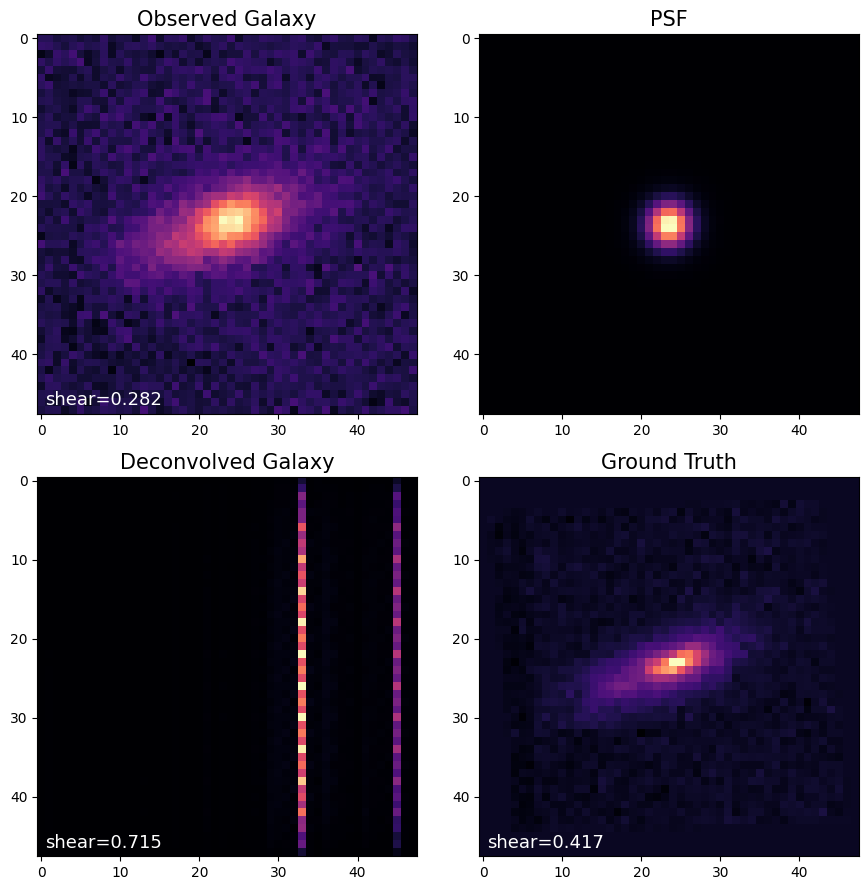

In [5]:
cmap = 'magma'

plt.figure(figsize=(9, 9))
plt.subplot(2,2,1)
plt.imshow(obs, cmap=cmap)
plt.title('Observed Galaxy', fontsize=15)
plt.title('shear={:.3f}'.format(estimate_shear(obs)[2]), loc='left', x=0.02, y=0, fontsize=13, color='white')

plt.subplot(2,2,2)
plt.imshow(psf, cmap=cmap)
plt.title('PSF', fontsize=15)

plt.subplot(2,2,3)
plt.imshow(rec, cmap=cmap)
plt.title('Deconvolved Galaxy', fontsize=15)
plt.title('shear={:.3f}'.format(estimate_shear(rec)[2]), loc='left', x=0.02, y=0, fontsize=13, color='white')

plt.subplot(2,2,4)
plt.imshow(gt, cmap=cmap)
plt.title('Ground Truth', fontsize=15)
plt.title('shear={:.3f}'.format(estimate_shear(gt)[2]), loc='left', x=0.02, y=0, fontsize=13, color='white')

plt.tight_layout()